<a href="https://colab.research.google.com/github/AnandKhandekar/Introduction-to-PyMC3--01/blob/master/Intro_to_PyMC3_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
**$Probabilisitic \;Programming \;using\; PyMC3$**  
***

Ref : Cam Davidson \\
REf : [Chris Fonnesbeck](https://github.com/fonnesbeck/PyMC3_DataScienceLA/blob/master/notebooks/1.%20Introduction%20to%20PyMC3.ipynb)

>Probabilistic programming allows for automatic Bayesian inference on user-defined probabilistic models. Recent advances in Markov chain Monte Carlo (MCMC) sampling allow inference on increasingly complex models. This class of MCMC, known as Hamiltonian Monte Carlo, requires gradient information which is often not readily available. PyMC3 is a new open source probabilistic programming framework written in Python that uses Theano to compute gradients via automatic differentiation as well as compile probabilistic programs on-the-fly to C for increased speed. Contrary to other probabilistic programming languages, PyMC3 allows model specification directly in Python code. The lack of a domain specific language allows for great flexibility and direct interaction with the model. 

> This example is taken from Chapter#1 "Probabilistic-Programming-and-Bayesian-Methods-for-Hackers" book written by Cam Davidson.

**Problem Statement**

You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this?

In [18]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 2.8MB/s 
  Found existing installation: arviz 0.8.3
    Uninstalling arviz-0.8.3:
      Successfully uninstalled arviz-0.8.3
     |████████████████████████████████| 911kB 2.5MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import scipy.stats as stats
from pymc3 import traceplot


(0.0, 74.0)

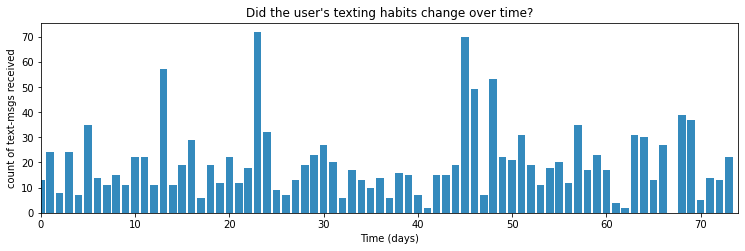

In [2]:
figsize(12.5, 3.5)
from numpy import genfromtxt
count_data = np.genfromtxt('/content/drive/My Drive/txtdata.csv', delimiter=',')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

ow can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of count data. Denoting day $i$'s text-message count by $C_i$
* $ C_i \sim \text{Poisson}(\lambda)  $

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations.


How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a switchpoint:

$$
\lambda = 
\begin{cases}
\lambda_1  \;\;\;\;\; \text{if } t \lt \tau \cr
\lambda_2 \;\;\;\;\;\text{if } t \ge \tau
\end{cases}
$$

If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the exponential distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

$$\begin{align}
\;\lambda_1 \sim \text{Exp}( \alpha ) \\\
\lambda_2 \sim \text{Exp}( \alpha )
\end{align}$$
$\alpha$ is called a hyper-parameter or parent variable.

Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice. A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$

* An alternative would be to have two priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some point during the observations.

What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a uniform prior belief to every possible day. This is equivalent to saying

$$\begin{align}    \tau \sim \text{DiscreteUniform(1,70) }\\\\
  \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}$$

***
# **Introducing PyMC3**
***

PyMC3 code is easy to read. The only novel thing should be the syntax. Simply remember that we are representing the model's components ($\tau, \lambda_1, \lambda_2$ ) as variables.

In [0]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In the code above, we create the PyMC3 variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC3's stochastic variables, so-called because they are treated by the back end as random number generators.

In [0]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

This code creates a new function lambda_, but really we can think of it as a random variable: the random variable $\lambda$ from above. The switch() function assigns lambda_1 or lambda_2 as the value of lambda_, depending on what side of tau we are on. The values of lambda_ up until tau are lambda_1 and the values afterwards are lambda_2.

Note that because lambda_1, lambda_2 and tau are random, lambda_ will be random. We are not fixing any variables yet.

In [0]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)


The variable observation combines our data, count_data, with our proposed data-generation scheme, given by the variable lambda_, through the observed keyword.

The code below will be explained in Chapter 3, but I show it here so you can see where our results come from. One can think of it as a learning step. The machinery being employed is called Markov Chain Monte Carlo (MCMC), which I also delay explaining until Chapter 3. This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$. We can plot a histogram of the random variables to see what the posterior distributions look like. Below, we collect the samples (called traces in the MCMC literature) into histograms.

In [6]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling chain 1, 0 divergences: 100%|██████████| 15000/15000 [00:05<00:00, 2616.28it/s]
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1c54f5898>,
      dtype=object)

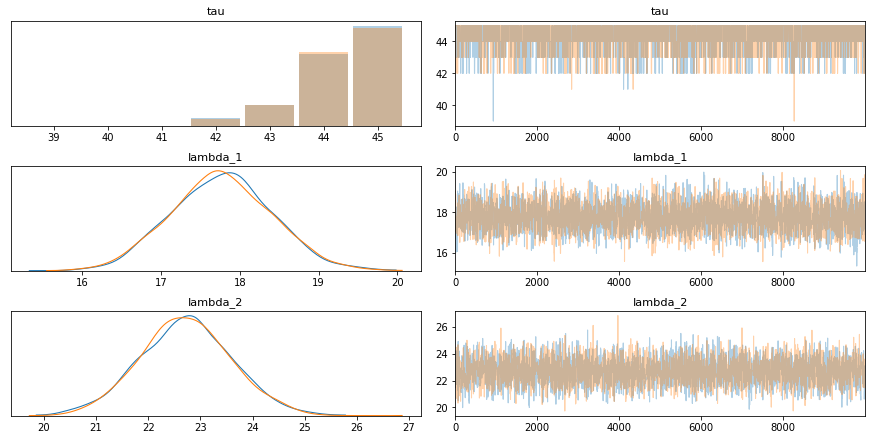

In [7]:
traceplot(trace)

In [0]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

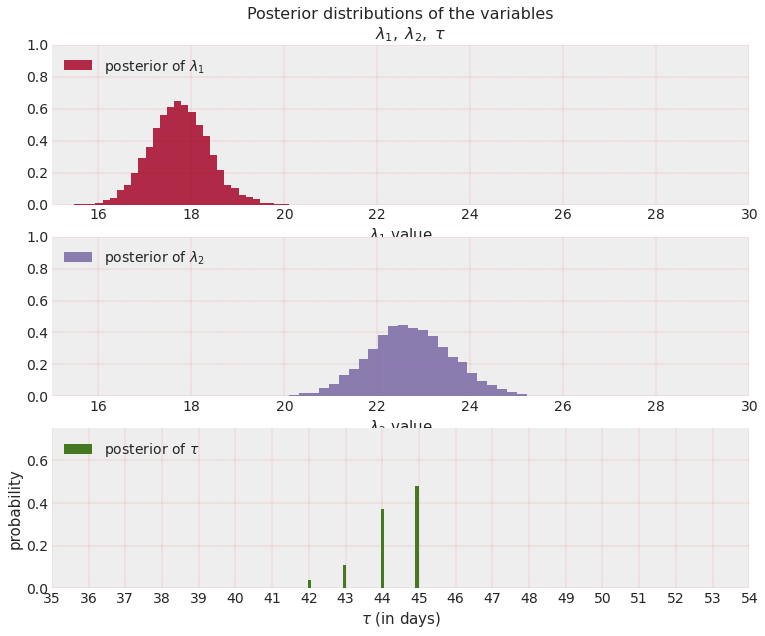

In [69]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.grid(color='r', linestyle=':', linewidth=0.3)

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.grid(color='r', linestyle=':', linewidth=0.3)

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.grid(color='r', linestyle=':', linewidth=0.3)

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")
plt.grid(color='r', linestyle=':', linewidth=0.3)

Interpretation
Recall that Bayesian methodology returns a distribution. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

What other observations can you make? If you look at the original data again, do these results seem reasonable?

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points.

Why would I want samples from the posterior, anyways?

We'll use the posterior samples to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to what is the expected value of $\lambda$ at time $t$?

In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$.

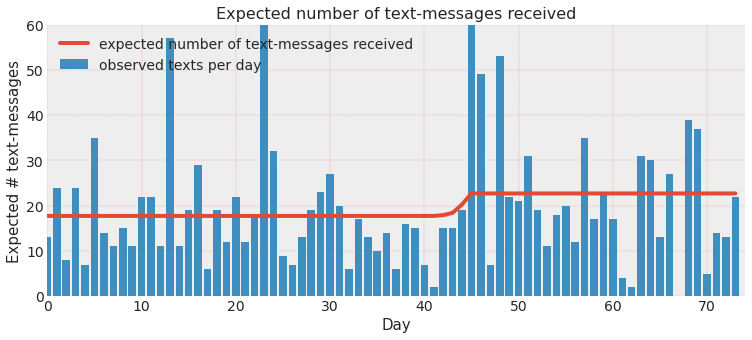

In [70]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of message count
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.95,
        label="observed texts per day")
plt.grid(color='r', linestyle=':', linewidth=0.3)
plt.legend(loc="upper left");


Our analysis shows strong support for believing the user's behavior did change ($\lambda_1$ would have been close in value to $\lambda_2$ had this not been true), and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior distribution). We can speculate what might have caused this: a cheaper text-message rate, a recent weather-to-text subscription, or perhaps a new relationship.

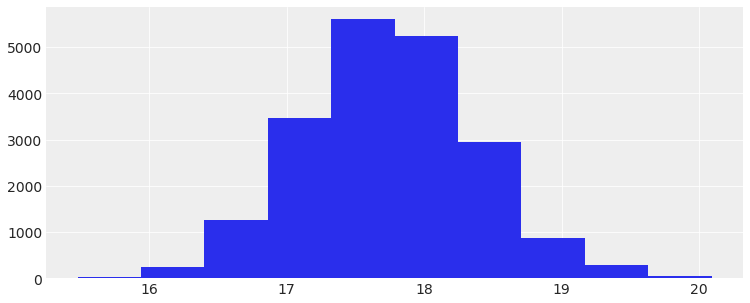

In [74]:
#from pymc3 import summary
#pm.summary(trace[5000:], varnames=['lambda_1_samples','lambda_2_samples','tau_samples'])
plt.hist(trace['lambda_1']);

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Arg

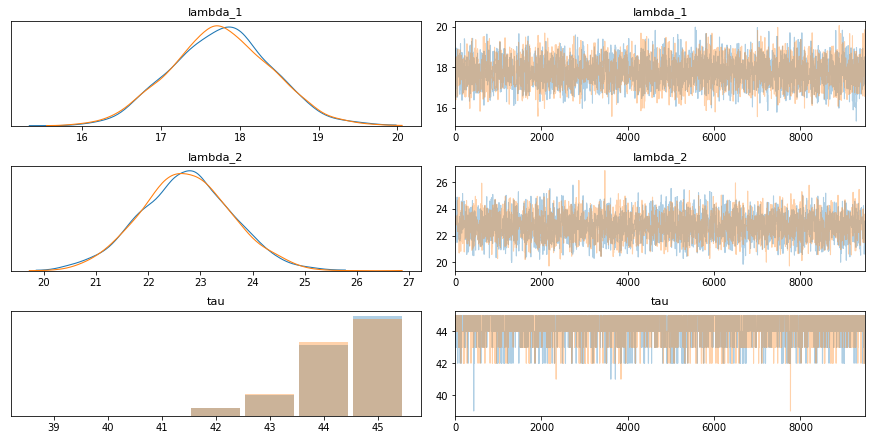

In [10]:
from pymc3 import traceplot

traceplot(trace[500:], varnames=['lambda_1', 'lambda_2', 'tau']);


In [11]:

from pymc3 import summary

summary(trace[500:], varnames=['lambda_1', 'lambda_2']) 

/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_1,17.767,0.635,16.545,18.878,0.011,0.008,3386.0,3386.0,3379.0,3482.0,1.0
lambda_2,22.729,0.871,21.086,24.368,0.015,0.010,3511.0,3511.0,3504.0,3956.0,1.0
